In [1]:
%matplotlib inline
import json 
from openeye import oechem, oequacpac
import fragmenter
import glob
from openmoltools import openeye
import matplotlib.pyplot as plt
import seaborn as sbn
import numpy as np

In [2]:
imatinib_oemols = fragmenter.chemi.file_to_oemols('Imatinib_for_am1_comparison.oeb')
gefitinib_oemols = fragmenter.chemi.file_to_oemols('Gefitinib_for_am1_comparison.oeb')

In [3]:
def get_bond_wbos(mols_wbos):
    """
    Collect all bonds wbos from list of oemols that have wbos calculated
    """
    bonds = {'rotors': {}, 'rings': {}, 'others': {}}
    for mol in mols_wbos:
        for bond in mol.GetBonds():
            a1 = bond.GetBgn()
            a2 = bond.GetEnd()
            if not a1.IsHydrogen() and not a2.IsHydrogen():
                if bond.IsRotor():
                    key = (bond.GetBgn().GetMapIdx(), bond.GetEnd().GetMapIdx())
                    if key not in bonds['rotors']:
                        bonds['rotors'][key] = []
                    bonds['rotors'][key].append(bond.GetData('WibergBondOrder'))
                elif bond.IsInRing():
                    key = (bond.GetBgn().GetMapIdx(), bond.GetEnd().GetMapIdx())
                    if key not in bonds['rings']:
                        bonds['rings'][key] = []
                    bonds['rings'][key].append(bond.GetData('WibergBondOrder'))
                else:
                    key = (bond.GetBgn().GetMapIdx(), bond.GetEnd().GetMapIdx())
                    if key not in bonds['others']:
                        bonds['others'][key] = []
                    bonds['others'][key].append(bond.GetData('WibergBondOrder'))
    return bonds

def plot_distributions(bond_keys, bond_wbos, name):
    """
    Plot distribution of wbos
    bond_keys: list of tuples for bonds to plot
    bond_wbos: dict of bond_tuple:wbos (return from get_bond_wbos) 
    name: str, name of molecule
    """
    # Generate WBO distributions
    colors = fragmenter.chemi._KELLYS_COLORS
    n = len(bond_keys)
    fig, axes = plt.subplots(n, 1)
    fig.dpi = 400
    x_min = 3
    x_max = 0
    for b in bond_keys:
        try:
            wbo = bond_wbos['rotors'][b]
        except KeyError:
            wbo = bond_wbos['others'][b]
        if min(wbo) < x_min:
            x_min = min(wbo)
        if max(wbo) > x_max:
            x_max = max(wbo)

    #sorted_rot_bonds = sorted(bonds['rotors'].keys())
    for i, bond in enumerate(bond_keys):
        try:
            wbo = bond_wbos['rotors'][bond]
        except KeyError:
            wbo = bond_wbos['others'][bond]
        ax = plt.subplot(n, 1, i+1)
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.patch.set_facecolor('none')
        sbn.kdeplot(wbo, shade= True, alpha=0.85, color=colors[i])
      #sbn.distplot(wbo, hist=False, rug=True, kde=False, color='black')
        sbn.kdeplot(wbo, lw=1.5, color=colors[i])
        #plt.axvline(x=wbo_s, ymin=0, ymax=1, color='black', linewidth=0.5)
        plt.xlim(x_min-0.05, x_max+0.05)
        plt.yticks([])
        #ax.set_yticklabels(bond_order_std_rot_bonds_opt['Imatinib']['bonds'], fontsize=6, rotation=0)
        #ax.yaxis.grid(False)
        ax.yaxis.set_label_coords(-0.05, 0)
        plt.ylabel(bond, rotation=0, size=8)
        if i != n-1:
            plt.xticks([])
        else:
            plt.xlabel('Bond order')
        if i == 0:
            #plt.legend(prop={'size': 10}, bbox_to_anchor=(1.35, 1))
            plt.title("{} WBO".format(name))
            overlap=0.5
    h_pad = 5 + (- 5*(1 + overlap))
    fig.tight_layout(h_pad=h_pad)
    plt.savefig('{}_single_bond_wbo.pdf'.format(name))

In [4]:
bonds_gefitinib = get_bond_wbos(gefitinib_oemols)
bonds_imatinib = get_bond_wbos(imatinib_oemols)

In [5]:
# Collect rotors of interest. This takes a bit of manual manipulation 
rotors_gefitinib = list(bonds_gefitinib['rotors'].keys())[:3] + [list(bonds_gefitinib['others'].keys())[0]] + list(bonds_gefitinib['rotors'].keys())[3:]
rotors_imatinib = list(bonds_imatinib['rotors'].keys())[:3] + [list(bonds_imatinib['others'].keys())[0]] + list(bonds_imatinib['rotors'].keys())[3:] + [list(bonds_imatinib['others'].keys())[-1]]

In [6]:
# generate highlighted molecules
fragmenter.chemi.highlight_bond_by_map_idx(gefitinib_oemols[0], bond_map_idx=rotors_gefitinib, map_idx=True, 
                                           label_scale=1.3, fname='gefitinib_highlighted_bonds.pdf')
fragmenter.chemi.highlight_bond_by_map_idx(imatinib_oemols[0], bond_map_idx=rotors_imatinib, map_idx=True, 
                                           label_scale=1.3, fname='imatinib_highlighted_bonds.pdf')

True

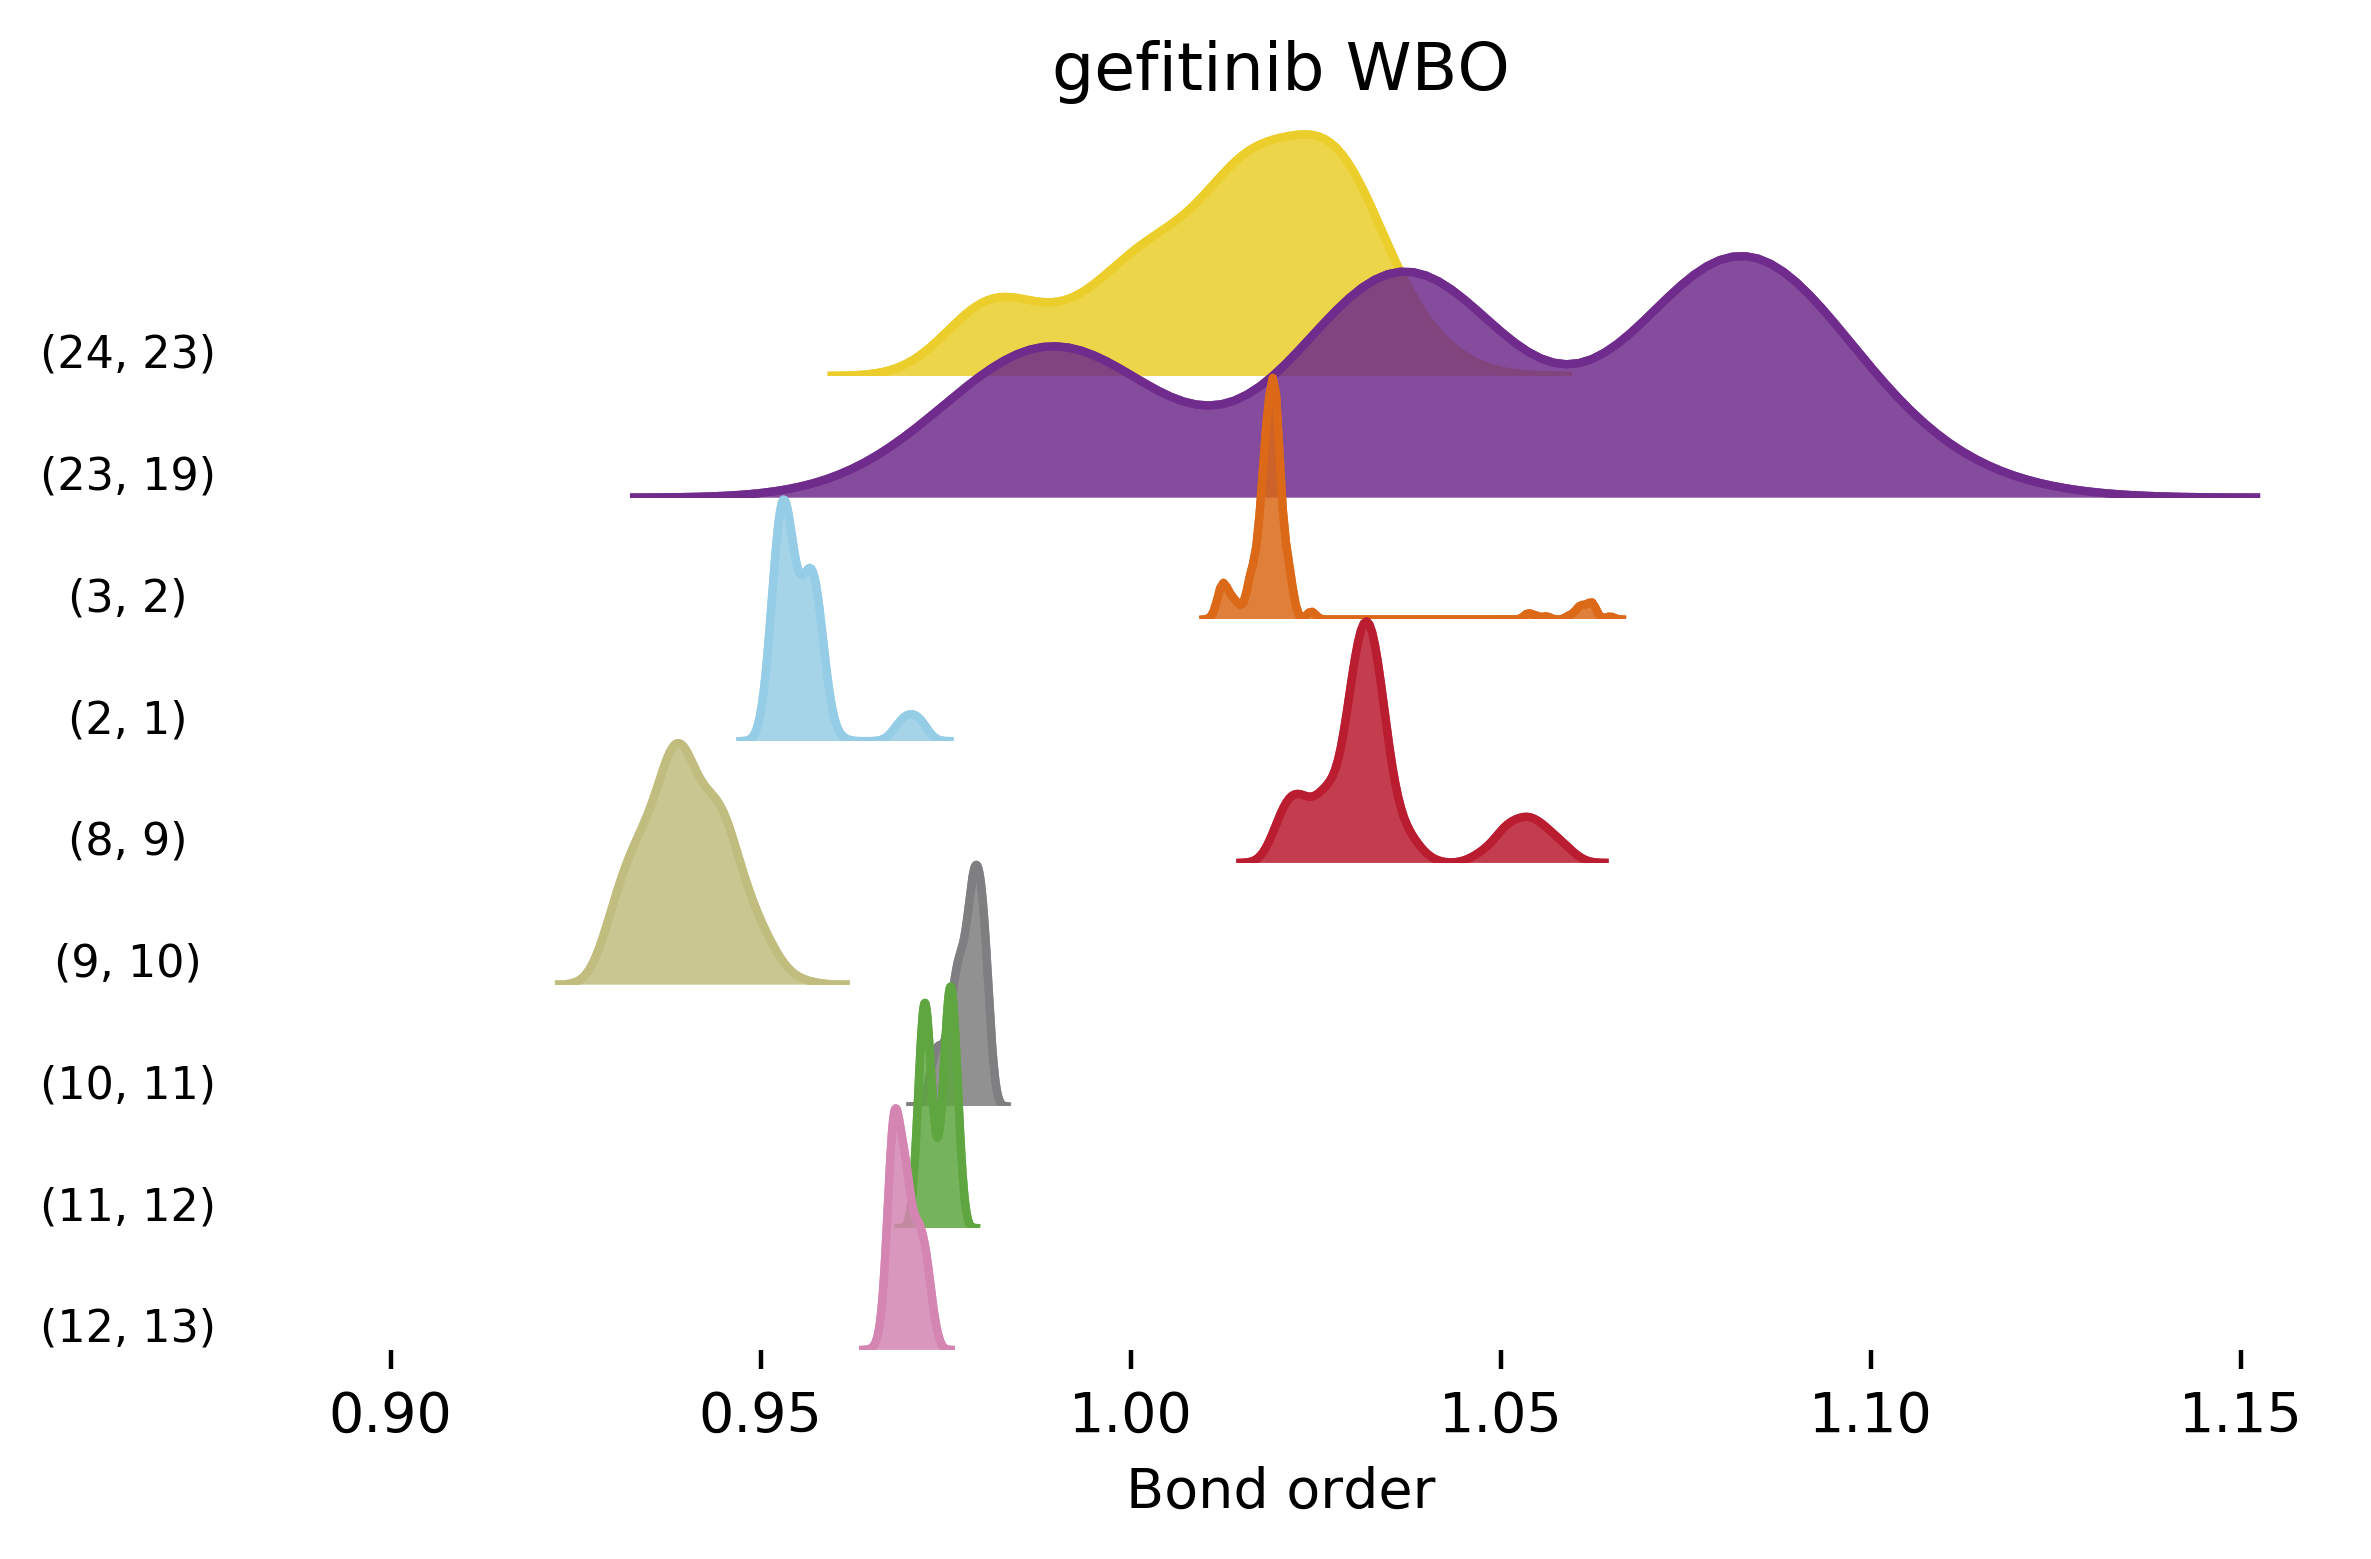

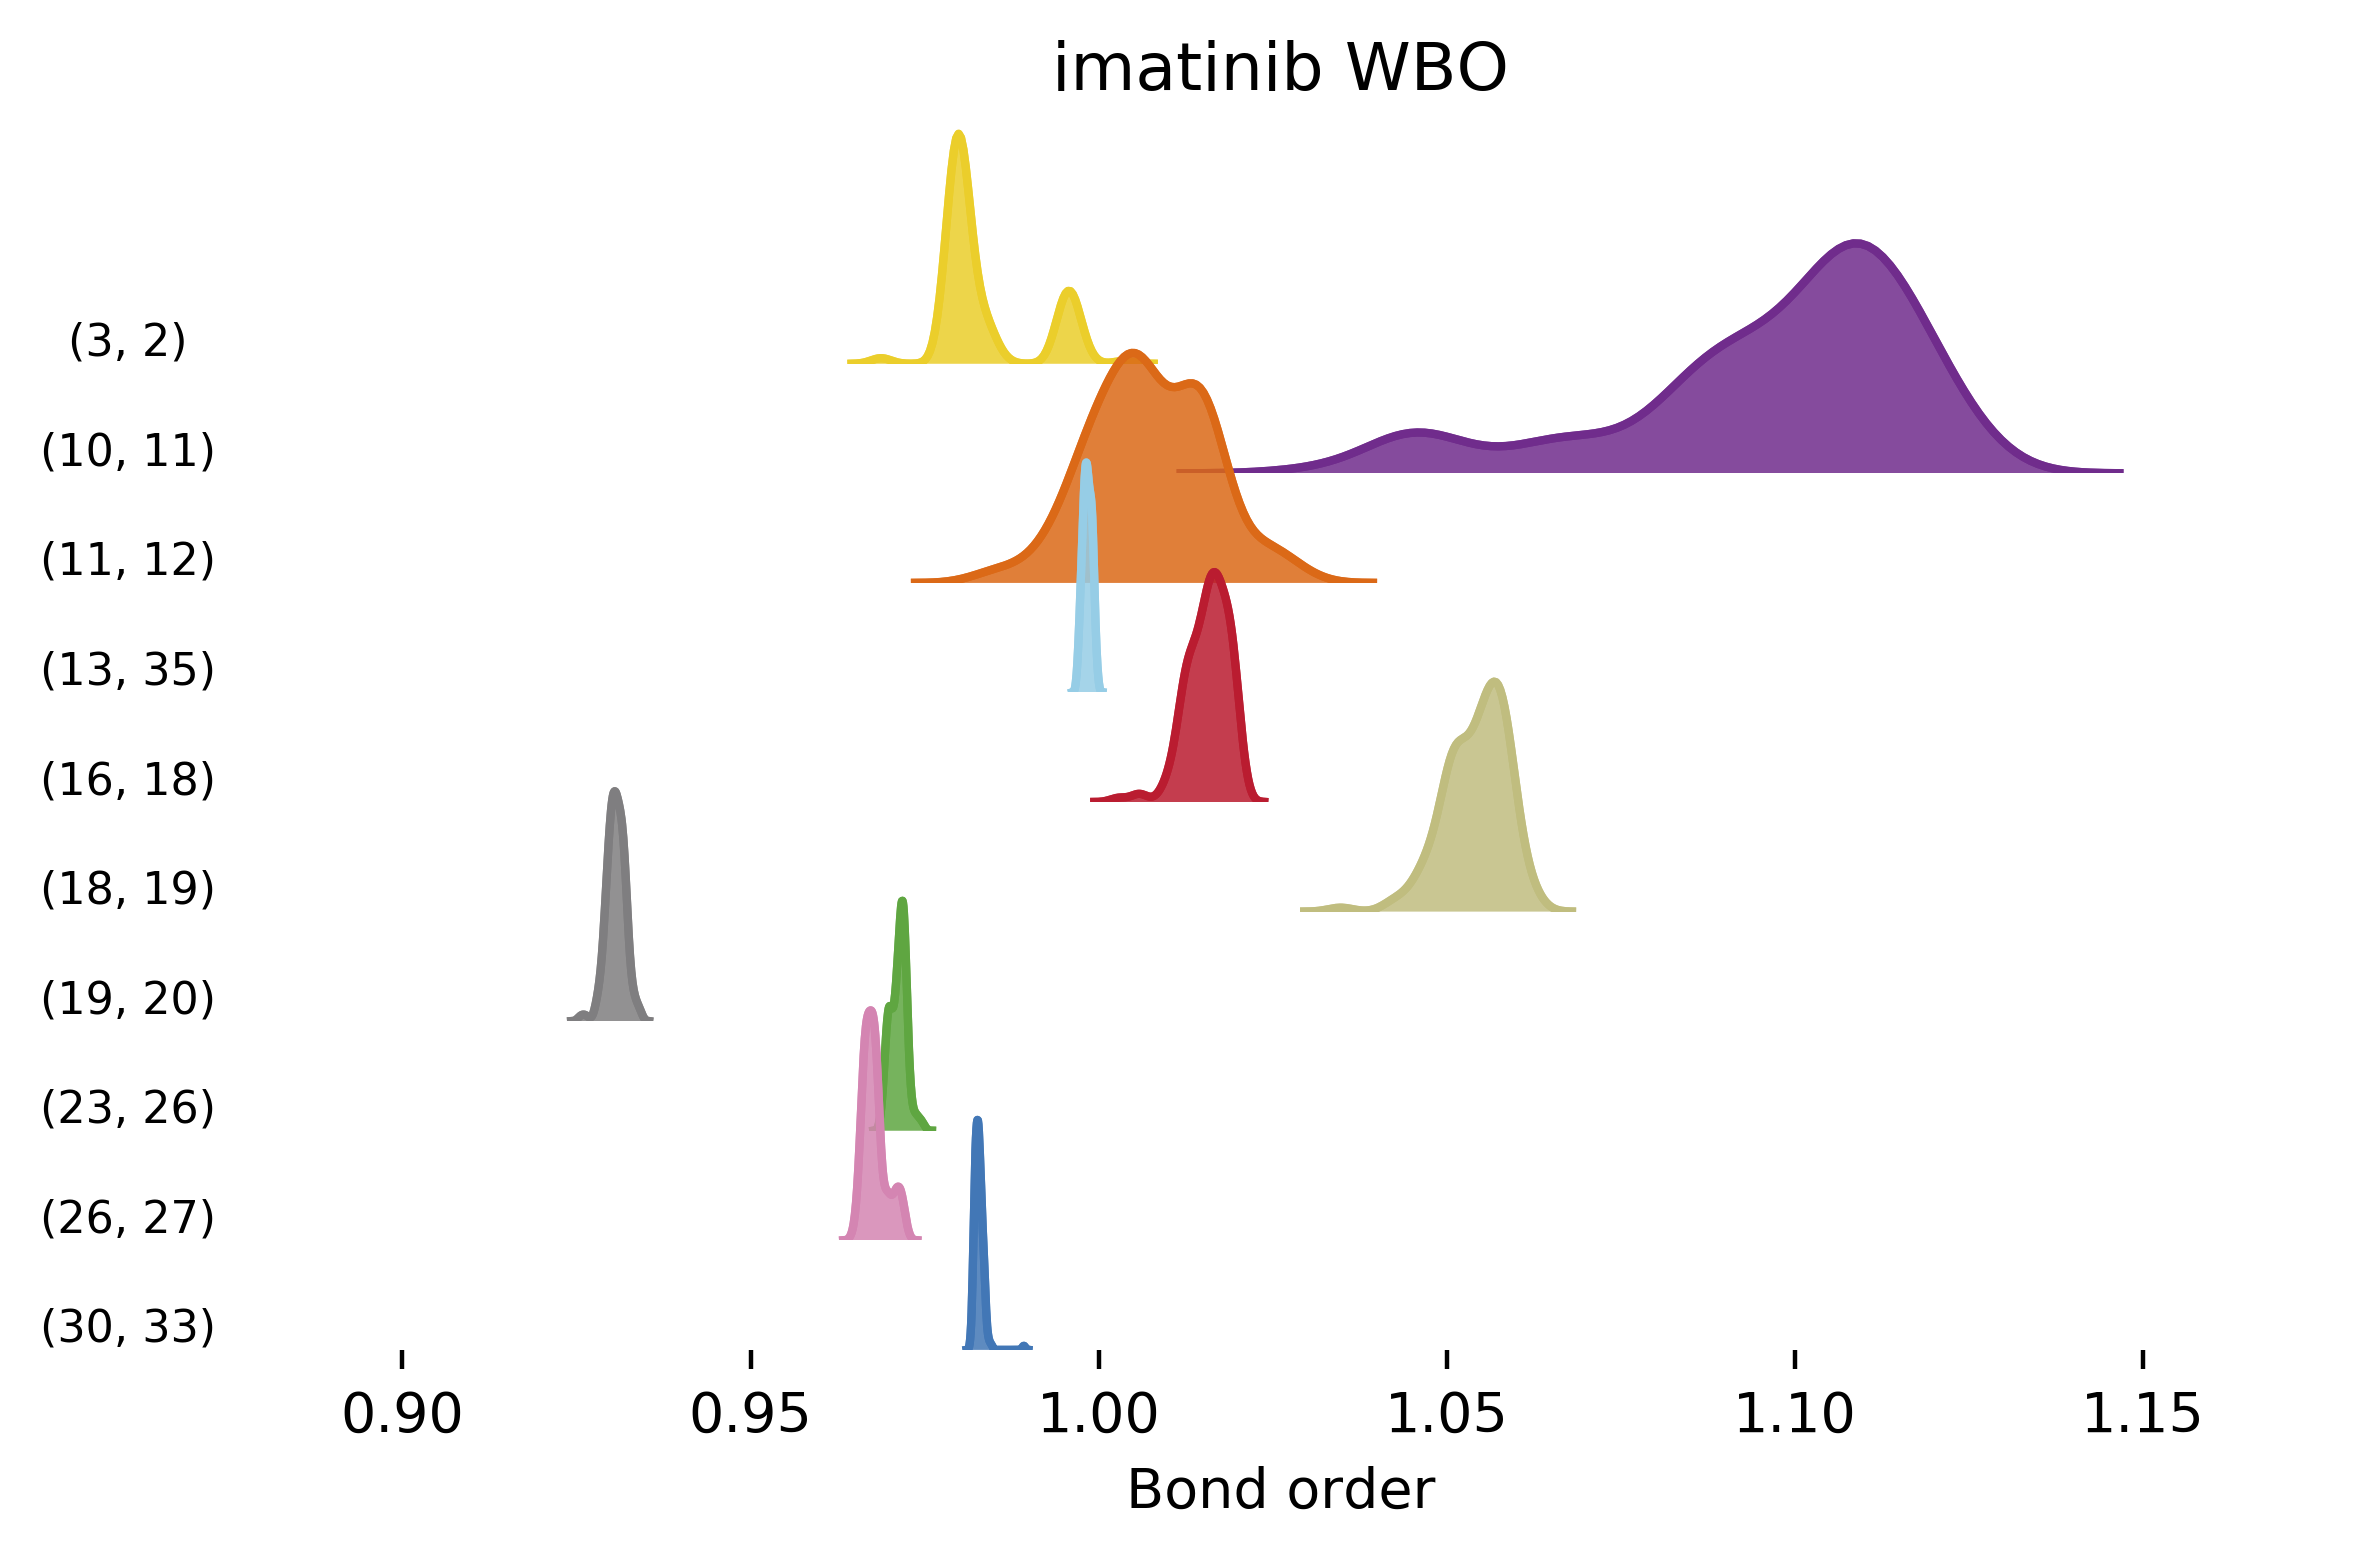

In [7]:
plot_distributions(rotors_gefitinib, bonds_gefitinib, name='gefitinib')
plot_distributions(rotors_imatinib, bonds_imatinib, name='imatinib')


In [8]:
# Generate correlation plots. Order bonds as it was ordered in the original hf3c calculation so it's easy to compare
all_bonds_gefitinib = [(3,2), (8,9), (9,10), (10,11), (11, 12), (12, 13), (23, 19), (24, 23), (2, 1), (27, 31), (28, 30)] + list(bonds_gefitinib['rings'].keys())[len(bonds_gefitinib['rings'])-6:] + list(bonds_gefitinib['rings'].keys())[:len(bonds_gefitinib['rings'])-6:]
all_bonds_wbos_gefitinib = {**bonds_gefitinib['rotors'], **bonds_gefitinib['rings'], **bonds_gefitinib['others']}
corr_coef_matrix_gefitinib = np.zeros((len(all_bonds_gefitinib), len(all_bonds_gefitinib)))
for i, bond_a in enumerate(all_bonds_gefitinib):
    for j, bond_b in enumerate(all_bonds_gefitinib):
            corr_coef = np.corrcoef(all_bonds_wbos_gefitinib[bond_a], 
                                    all_bonds_wbos_gefitinib[bond_b])
            corr_coef_matrix_gefitinib[i][j] = corr_coef[0, 1]

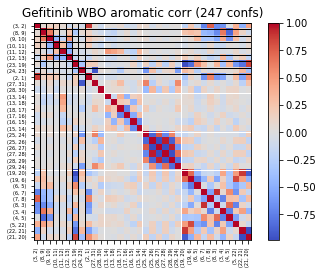

In [9]:
fig, ax = plt.subplots()
corr = ax.imshow(corr_coef_matrix_gefitinib, cmap='coolwarm')
ax.xaxis.set_ticks_position('bottom')

plt.xticks(np.arange(len(all_bonds_gefitinib)), all_bonds_gefitinib, rotation='vertical', size=5.0);
plt.yticks(np.arange(len(all_bonds_gefitinib)), all_bonds_gefitinib, size=5.0);

 # Draw squares around rings
linewidth = 1.0
x_1 = len(bonds_gefitinib['rotors'])+len(bonds_gefitinib['others']) - 0.5
ax.axvline(x=x_1, color='white', linewidth=linewidth)
ax.axhline(y=x_1, color='white', linewidth=linewidth)
ax.axvline(x=x_1+6, color='white', linewidth=linewidth)
ax.axhline(y=x_1+6, color='white', linewidth=linewidth)
ax.axvline(x=x_1+12, color='white', linewidth=linewidth)
ax.axhline(y=x_1+12, color='white', linewidth=linewidth)

for rot in range(len(bonds_gefitinib['rotors'])):
        ax.axvline(x=rot-0.5, color='black', linewidth=linewidth)
        ax.axvline(x=rot+0.5, color='black', linewidth=linewidth)
        ax.axhline(y=rot-0.5, color='black', linewidth=linewidth)
        ax.axhline(y=rot+0.5, color='black', linewidth=linewidth)
    
    
#line_placement_aliphatic = np.cumsum(ring_sizes_aliphatic)
fig.colorbar(corr);
ax.set_title('Gefitinib WBO aromatic corr ({} confs)'.format(len(gefitinib_oemols)))
fig.savefig('gefitinib_WBO_correlation.pdf')

In [10]:
# Generate correlation plots. Order bonds as it was ordered in the original hf3c calculation so it's easy to compare
ring_bonds = bonds_imatinib['rings']
rings = list(ring_bonds.keys())[len(ring_bonds)-6:] + list(ring_bonds.keys())[:len(ring_bonds.keys())-6]
all_bonds_imatinib = list(bonds_imatinib['rotors'].keys()) + list(bonds_imatinib['others'].keys()) + rings
all_bonds_wbos_imatinib = {**bonds_imatinib['rotors'], **bonds_imatinib['rings'], **bonds_imatinib['others']}
corr_coef_matrix_imatinib = np.zeros((len(all_bonds_imatinib), len(all_bonds_imatinib)))
for i, bond_a in enumerate(all_bonds_imatinib):
    for j, bond_b in enumerate(all_bonds_imatinib):
            corr_coef = np.corrcoef(all_bonds_wbos_imatinib[bond_a], 
                                    all_bonds_wbos_imatinib[bond_b])
            corr_coef_matrix_imatinib[i][j] = corr_coef[0, 1]

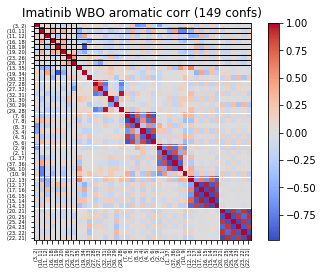

In [11]:
fig, ax = plt.subplots()
corr = ax.imshow(corr_coef_matrix_imatinib, cmap='coolwarm')
ax.xaxis.set_ticks_position('bottom')

plt.xticks(np.arange(len(all_bonds_imatinib)), all_bonds_imatinib, rotation='vertical', size=5.0);
plt.yticks(np.arange(len(all_bonds_imatinib)), all_bonds_imatinib, size=5.0);

 # Draw squares around rings
linewidth = 1.0
x_1 = len(bonds_imatinib['rotors'])+len(bonds_imatinib['others']) - 0.5
for i in range(0, 30, 6):
    ax.axvline(x=x_1+i, color='white', linewidth=linewidth)
    ax.axhline(y=x_1+i , color='white', linewidth=linewidth)


for rot in range(len(bonds_imatinib['rotors'])):
        ax.axvline(x=rot-0.5, color='black', linewidth=linewidth)
        ax.axvline(x=rot+0.5, color='black', linewidth=linewidth)
        ax.axhline(y=rot-0.5, color='black', linewidth=linewidth)
        ax.axhline(y=rot+0.5, color='black', linewidth=linewidth)
    
    
#line_placement_aliphatic = np.cumsum(ring_sizes_aliphatic)
fig.colorbar(corr);
ax.set_title('Imatinib WBO aromatic corr ({} confs)'.format(len(imatinib_oemols)))
fig.savefig('imatinib_WBO_correlation.pdf')